In [2]:
import cv2
import os
from tqdm import tqdm
import numpy as np

def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular region
    """
    # Handle grayscale inputs
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # Convert to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Thresholding and morphological operations
    _, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # Find contours - version compatible way
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Handle different OpenCV versions
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    # If no contours found, return original image
    if not cnts:
        return img
    
    c = max(cnts, key=cv2.contourArea)
    
    # Find extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # Crop with boundary checks
    ADD_PIXELS = 10  # Added padding for better cropping
    y1 = max(0, extTop[1] - ADD_PIXELS)
    y2 = min(img.shape[0], extBot[1] + ADD_PIXELS)
    x1 = max(0, extLeft[0] - ADD_PIXELS)
    x2 = min(img.shape[1], extRight[0] + ADD_PIXELS)
    
    return img[y1:y2, x1:x2]

def preprocess_dataset():
    # Configuration
    BASE_PATH = r"C:\Users\Shafi.09\AnocondaProjects\BrainT\R_datasets"
    ORIGINAL_PATH = os.path.join(BASE_PATH, "masoud_nickparvar_dataset")
    PREPROCESSED_PATH = os.path.join(BASE_PATH, "preprocessed_masoud_nickparvar_dataset")
    IMG_SIZE = 256
    
    # Class directories
    CLASSES = ['glioma', 'meningioma', 'pituitary', 'notumor']
    SPLITS = ['Training', 'Testing']
    
    # Process each split and class
    for split in SPLITS:
        for cls in CLASSES:
            # Set up paths
            src_dir = os.path.join(ORIGINAL_PATH, split, cls)
            dest_dir = os.path.join(PREPROCESSED_PATH, split, cls)
            
            # Skip if source directory doesn't exist
            if not os.path.exists(src_dir):
                print(f"⚠️ Directory not found: {src_dir}. Skipping...")
                continue
                
            # Create destination directory if not exists
            os.makedirs(dest_dir, exist_ok=True)
            
            # Get list of image files
            img_files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            if not img_files:
                print(f"⚠️ No images found in: {src_dir}")
                continue
                
            # Process images with progress bar
            for img_file in tqdm(img_files, desc=f"Processing {split}/{cls}"):
                try:
                    # Read image
                    img_path = os.path.join(src_dir, img_file)
                    img = cv2.imread(img_path)
                    
                    if img is None:
                        print(f"Warning: Could not read image {img_path}")
                        continue
                    
                    # Crop and resize
                    cropped = crop_img(img)
                    resized = cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))
                    
                    # Save processed image
                    save_path = os.path.join(dest_dir, img_file)
                    cv2.imwrite(save_path, resized)
                    
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
    
    print("\nPreprocessing completed successfully!")
    print(f"Processed dataset saved to: {PREPROCESSED_PATH}")

if __name__ == "__main__":
    preprocess_dataset()

Processing Testing/notumor: 100%|██████████| 309/309 [00:01<00:00, 236.67it/s]


Preprocessing completed successfully!
Processed dataset saved to: C:\Users\Shafi.09\AnocondaProjects\BrainT\R_datasets\preprocessed_masoud_nickparvar_dataset


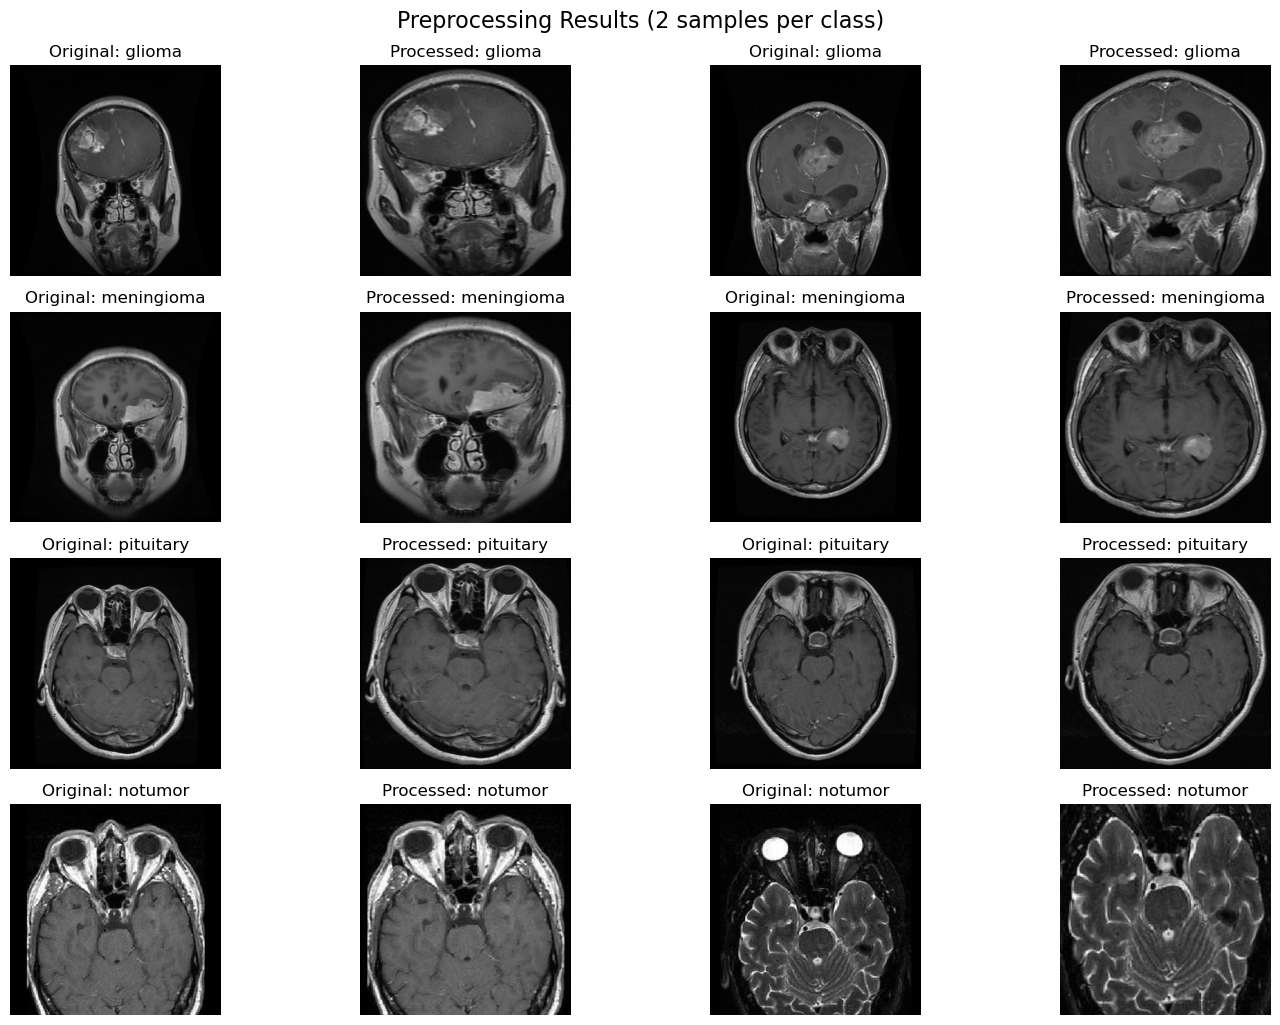

In [4]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Configuration - Update these paths to match your environment
BASE_PATH = r"C:\Users\Shafi.09\AnocondaProjects\BrainT\R_datasets"
ORIGINAL_PATH = os.path.join(BASE_PATH, "masoud_nickparvar_dataset")
PREPROCESSED_PATH = os.path.join(BASE_PATH, "preprocessed_masoud_nickparvar_dataset")

# Select sample images to display
SAMPLES_PER_CLASS = 2
CLASSES = ['glioma', 'meningioma', 'pituitary', 'notumor']
SPLIT = 'Training'  # Can change to 'Testing' if you want test samples

# Create the visualization
plt.figure(figsize=(15, 10))
plot_index = 1

for cls in CLASSES:
    # Get original and processed image paths
    orig_dir = os.path.join(ORIGINAL_PATH, SPLIT, cls)
    proc_dir = os.path.join(PREPROCESSED_PATH, SPLIT, cls)
    
    # Get sample images
    orig_images = [f for f in os.listdir(orig_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:SAMPLES_PER_CLASS]
    
    for img_file in orig_images:
        # Load original image
        orig_path = os.path.join(orig_dir, img_file)
        orig_img = cv2.imread(orig_path)
        if orig_img is not None:
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        else:
            orig_img = np.zeros((256, 256, 3), dtype=np.uint8)
        
        # Load processed image
        proc_path = os.path.join(proc_dir, img_file)
        if os.path.exists(proc_path):
            proc_img = cv2.imread(proc_path)
            if proc_img is not None:
                proc_img = cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB)
            else:
                proc_img = np.zeros((256, 256, 3), dtype=np.uint8)
        else:
            proc_img = np.zeros((256, 256, 3), dtype=np.uint8)
        
        # Plot original
        plt.subplot(len(CLASSES), SAMPLES_PER_CLASS*2, plot_index)
        plt.imshow(orig_img)
        plt.title(f"Original: {cls}")
        plt.axis('off')
        plot_index += 1
        
        # Plot processed
        plt.subplot(len(CLASSES), SAMPLES_PER_CLASS*2, plot_index)
        plt.imshow(proc_img)
        plt.title(f"Processed: {cls}")
        plt.axis('off')
        plot_index += 1

plt.tight_layout()
plt.suptitle(f"Preprocessing Results ({SAMPLES_PER_CLASS} samples per class)", fontsize=16, y=1.02)
plt.show()

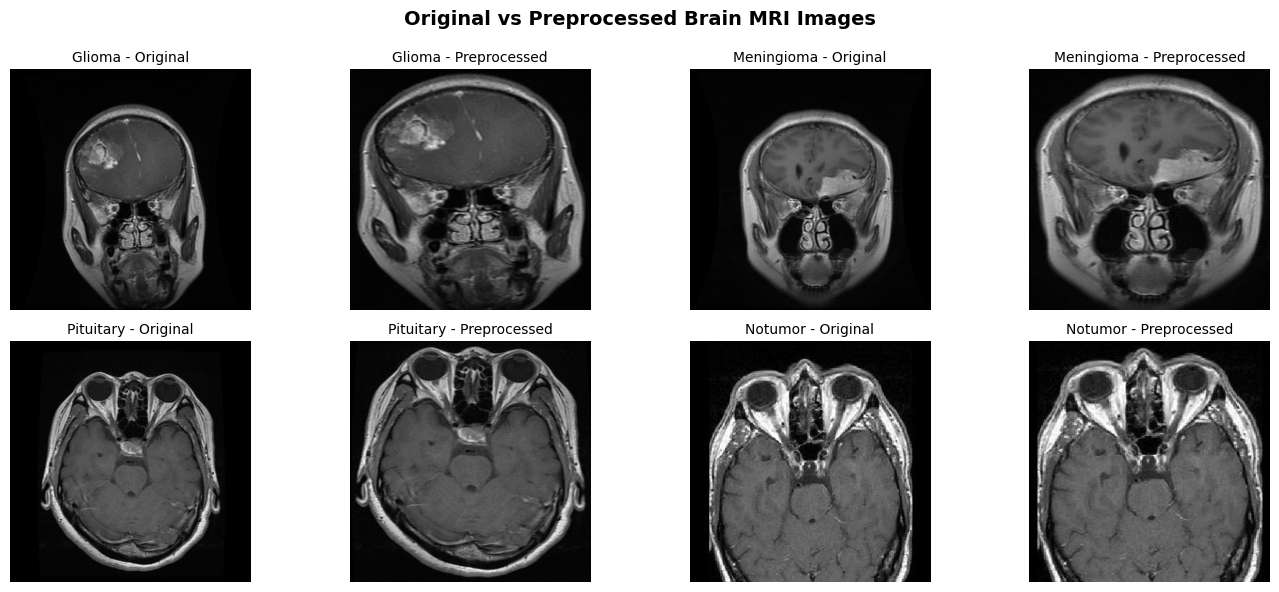

In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Config paths
BASE_PATH = r"C:\Users\Shafi.09\AnocondaProjects\BrainT\R_datasets"
ORIGINAL_PATH = os.path.join(BASE_PATH, "masoud_nickparvar_dataset")
PREPROCESSED_PATH = os.path.join(BASE_PATH, "preprocessed_masoud_nickparvar_dataset")

# Parameters
CLASSES = ['glioma', 'meningioma', 'pituitary', 'notumor']
SPLIT = 'Training'
SAMPLES_PER_CLASS = 1  # 1 image per class

# Create 2-row layout (4 classes × 2 images = 8 subplots: 4 per row)
fig, axs = plt.subplots(2, 4, figsize=(14, 6))
axs = axs.flatten()

for idx, cls in enumerate(CLASSES):
    orig_dir = os.path.join(ORIGINAL_PATH, SPLIT, cls)
    proc_dir = os.path.join(PREPROCESSED_PATH, SPLIT, cls)

    # Select one image
    img_files = [f for f in os.listdir(orig_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not img_files:
        continue

    img_file = img_files[0]

    # Load original
    orig_path = os.path.join(orig_dir, img_file)
    orig_img = cv2.imread(orig_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB) if orig_img is not None else np.zeros((256, 256, 3), dtype=np.uint8)

    # Load preprocessed
    proc_path = os.path.join(proc_dir, img_file)
    proc_img = cv2.imread(proc_path)
    proc_img = cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB) if proc_img is not None else np.zeros((256, 256, 3), dtype=np.uint8)

    # Plot original
    axs[2 * idx].imshow(orig_img)
    axs[2 * idx].set_title(f"{cls.capitalize()} - Original", fontsize=10)
    axs[2 * idx].axis('off')

    # Plot processed
    axs[2 * idx + 1].imshow(proc_img)
    axs[2 * idx + 1].set_title(f"{cls.capitalize()} - Preprocessed", fontsize=10)
    axs[2 * idx + 1].axis('off')

# Adjust spacing
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.suptitle("Original vs Preprocessed Brain MRI Images", fontsize=14, weight='bold')
plt.show()